In [1]:
import numpy as np
from scipy.linalg import expm, kron
from itertools import combinations, product
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import QMultiAdapt
from multiprocessing import Pool
from QMultiAdapt.src.solver import solve_avq_trajectory
from effh import EffectiveHamiltonian
from ansatz import Ansatz
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'QMultiAdapt'

FMO Complex

In [3]:
H = [
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
]
H_fmo= np.pad(H, ((0, 3), (0, 3)), mode='constant')

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define the alpha operators
Llist_f = [(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(L_temp)
Llist_f_padded = [np.pad(matrix, ((0, 3), (0, 3)), mode='constant') for matrix in Llist_f]

# print(np.shape(H))
# print(np.shape(Llist_f_padded))

# u0 = [[0], [1], [0], [0], [0]]
u0_fmo = np.zeros(8,dtype=np.complex_)
u0_fmo[1] = 1
# print(u0_fmo)

In [4]:
# Result class remains unchanged
class Result:
    def __init__(self, t, psi, energy, pop, theta, A, jump_t, jump_L, status):
        self.t = t
        self.psi = psi
        self.energy = energy
        self.pop = pop
        self.theta = theta 
        self.A = A
        self.jump_t = jump_t
        self.jump_L = jump_L
        self.status = status

# Define the function to solve a trajectory (must be at top-level for multiprocessing)
# def solve_avq_trajectory(H, ansatz, tf, dt):
#     # Dummy function content, replace with actual trajectory solving code
#     return Result(t=[0], psi=[1], energy=[1], pop=[1], theta=[1], A=[1], jump_t=[], jump_L=[], status='finished')

# Parallel execution of trajectories
def run_trajectories(num_trajectory, H, ansatz, tf, dt):
    # Create a list of tuples with the required parameters for each trajectory
    param_list = [(H, ansatz, tf, dt) for _ in range(num_trajectory)]
    
    with Pool() as pool:
        results = pool.starmap(solve_avq_trajectory, param_list)
    
    return results

# Guard for multiprocessing in Jupyter
if __name__ == "__main__":
    # Define your parameters (these are placeholders)
    tf = 450
    dt = 5
    num_trajectory = 400
    H = EffectiveHamiltonian([H_fmo], [Llist_f_padded])
    ansatz = Ansatz(u0_fmo, relrcut=1e-5)

    # Running the parallel trajectories
    results = run_trajectories(num_trajectory, H, ansatz, tf, dt)


timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep:timestep: 5
timestep: 5
timestep: 5
 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep:timestep: 5
 5
timestep: 5
timestep: 5
timestep: 5
timestep: 5
timestep: timestep: 5
timestep: 5
5
timestep: 5
timestep: 5
timestep: 5
timestep:timeste

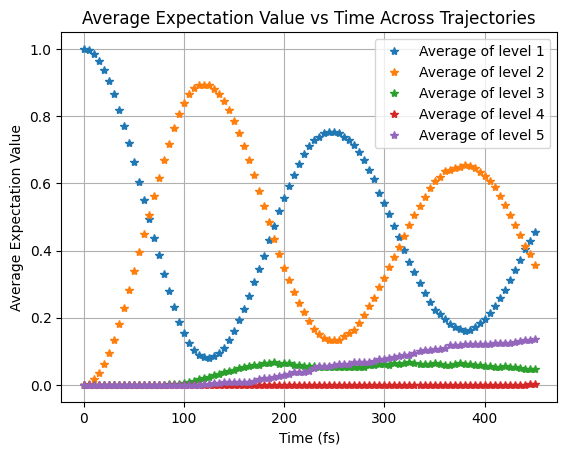

In [5]:
Mexp_f = [
    np.diag([0, 1, 0, 0, 0,0,0,0]),
    np.diag([0, 0, 1, 0, 0,0,0,0]),
    np.diag([0, 0, 0, 1, 0,0,0,0]),
    np.diag([1, 0, 0, 0, 0,0,0,0]),
    np.diag([0, 0, 0, 0, 1,0,0,0])
]

# Assuming num_trajectory, Mexp_f, and results are already defined

# Storage for accumulating the expectation values to compute the average
average_expectation_values = []

# Loop over each trajectory
for j in range(0, num_trajectory):
    # Loop over each observable
    for k, observable in enumerate(Mexp_f):
        expectation_values = []
        
        # Calculate expectation values for the current observable
        for i, psi in enumerate(results[j].psi):
            psi_dagger = np.conjugate(psi).T
            rho = np.outer(psi, psi_dagger)  # Calculate the density matrix
            expectation_value = np.trace(np.dot(rho, observable))  # Expectation value
            
            expectation_values.append(expectation_value.real)  # Append the real part of the expectation value
        
        # Store the expectation values for averaging later
        if len(average_expectation_values) <= k:
            average_expectation_values.append(np.array(expectation_values))  # Initialize the list
        else:
            average_expectation_values[k] += np.array(expectation_values)  # Accumulate values

        # Convert time to femtoseconds
        results_t_converted = [t for t in results[0].t]
        
        # Plot the expectation values for the current observable
        # plt.plot(results_t_cxonverted, expectation_values, label=f"Observable {k+1}")
    
    # Labeling the plot for each trajectory
    # plt.xlabel('Time (fs)')
    # plt.ylabel('Expectation Value')
    # plt.title(f'Expectation Value vs Time for Trajectory {j+1}')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

# After looping through all trajectories, plot the average

# Finalize the average by dividing by the number of trajectories
average_expectation_values = [ev / num_trajectory for ev in average_expectation_values]


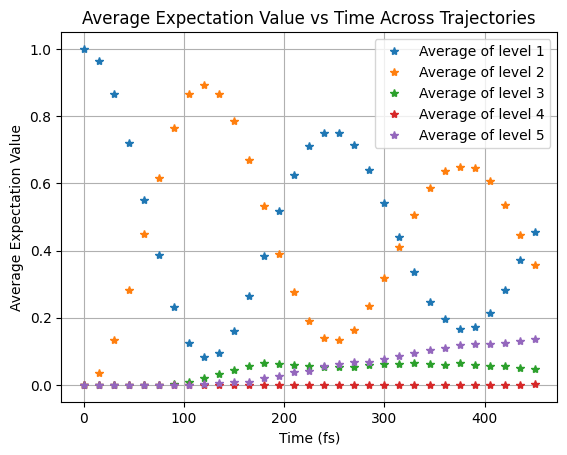

In [9]:

# Plot the average of all the observables
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], '*', label=f"Average of level {k+1}")

# Label the plot for the average
plt.xlabel('Time (fs)')
plt.ylabel('Average Expectation Value')
plt.title('Average Expectation Value vs Time Across Trajectories')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from qutip import mesolve, Qobj
import numpy as np
import matplotlib.pyplot as plt
def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect

In [12]:
# Hamiltonian
H = Qobj([
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
])

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define the alpha operators
Llist_f = [Qobj(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [Qobj(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(Qobj(L_temp))

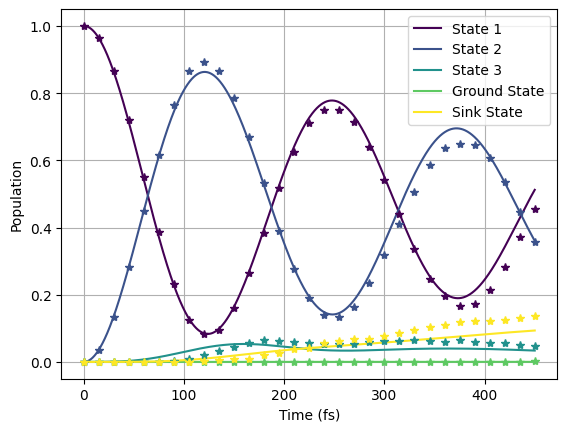

In [25]:
# Measurement operators
Mexp_f = [
    Qobj(np.diag([0, 1, 0, 0, 0])),
    Qobj(np.diag([0, 0, 1, 0, 0])),
    Qobj(np.diag([0, 0, 0, 1, 0])),
    Qobj(np.diag([1, 0, 0, 0, 0])),
    Qobj(np.diag([0, 0, 0, 0, 1]))
]

# Time evolution
times = np.linspace(0.0, 450.0, 2000)
psi0_f = Qobj([[0], [1], [0], [0], [0]])

# Using qutip_propagation function
population = qutip_prop(H, psi0_f, times, Llist_f, Mexp_f)

# Plotting the results
# fig, ax = plt.subplots()
labels = ["State 1", "State 2", "State 3", "Ground State", "Sink State"]
# import matplotlib.pyplot as plt

# Define a colormap for consistent coloring
colors = plt.cm.viridis(np.linspace(0, 1, len(population)))

# First plot for population vs times
for i, (expec, label) in enumerate(zip(population, labels)):
    plt.plot(times, expec, label=label, color=colors[i])

# Second plot for average_expectation_values vs results_t_converted
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], '*', color=colors[k])

# Set labels, title, and grid
plt.xlabel('Time (fs)')
plt.ylabel('Population')
# plt.title('Average Expectation Value vs Time Across Trajectories')
plt.legend()
plt.grid(True)
plt.show()

